# NIH CXR Database Image Classifier using VGG16 and Random Forrest

In [6]:
"""
Feature Extractor: NN pretained on InceptionV3
Output layer(s): Single Dense laeyr - traditional machine learning classifiers
Inspired by Sreenivas Bhattiprolu's classifier of similar approach
https://github.com/bnsreenu/python_for_microscopists/blob/master/158_classification_CNN_RF.py
"""
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
import tensorflow as tf
import seaborn as sns
from sklearn import preprocessing, metrics

In [7]:
#UTILITY FUCTION FOR TIME STAMPS
import calendar, time
from datetime import datetime
def getTimeStamp():
  current_GMT = time.gmtime()  # Current GMT time in a tuple format
  ts = calendar.timegm(current_GMT)   # ts stores timestamp
  date_time = datetime.fromtimestamp(ts)
  return date_time.strftime("%m%d-%H%M%S")  # convert timestamp to string in dd-mm-yyyy HH:MM:SS

In [8]:
# SHOW US WHAT YAH GOT
import sys
print(f"GPU: {tf.config.list_physical_devices('GPU')}  ")
print(f"CPU: {tf.config.list_physical_devices('CPU')}  ")
print(f"Python {sys.version}\nTensorflow{tf.__version__}")

GPU: []  
CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]  
Python 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
Tensorflow2.9.1


In [9]:
# If running on google colab, mount colab drive
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print('Not running on CoLab')

Not running on CoLab


In [10]:
WORKING_DIR_TS = os.getcwd()
WORKING_DIR_TS += '/'
if 'google.colab' in str(get_ipython()): #if working on google colab google colab
  WORKING_DIR_TS = '/content/drive/MyDrive/' #this is where files actually reside on google colab (that is on a mounted google drive)
WORKING_DIR_TS

'/Users/white/Documents/AlexProjects/DICOM_OCC_MED/'

In [11]:
# DEFINE CONSTANSTS
SIZE = 512  #Resize images, note original input shape for VGG is (224,244,3)
MAX_NUMBER_OF_EACH_FINDING = 525 #Total number of image for both testing and training
OVER_UNDER_SAMPLE_COUNT =2000
LIMIT_SAMPLE_TO_FINDINGS = ['No Finding' ,'Infiltration','Fibrosis'] #['No Finding' ,'Infiltration','Cardiomegaly' ,'Effusion','Mass','Fibrosis']
# MIN_AGE,MAX_AGE = 18,85
#BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS=10

#### TFDS: GET DATA FROM FILES with TF DATASETS

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dicom/NIH_1stPA_Norm_Fib',
    validation_split=0.2,
    subset="training",
    seed=38,
    image_size=(SIZE,SIZE),
    #batch_size=BATCH_SIZE,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'dicom/NIH_1stPA_Norm_Fib',
    validation_split=0.2,
    subset="validation",
    seed=38,
    image_size=(SIZE,SIZE),
    #batch_size=BATCH_SIZE,
)
## SETUP FOR CACHE AND BATCH AUTOTUNING
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 7007 files belonging to 2 classes.
Using 5606 files for training.


2022-08-22 19:17:15.507008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 7007 files belonging to 2 classes.
Using 1401 files for validation.


In [13]:
list(train_ds.take(1))[0][1]

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

['Fibrosis', 'No Finding']

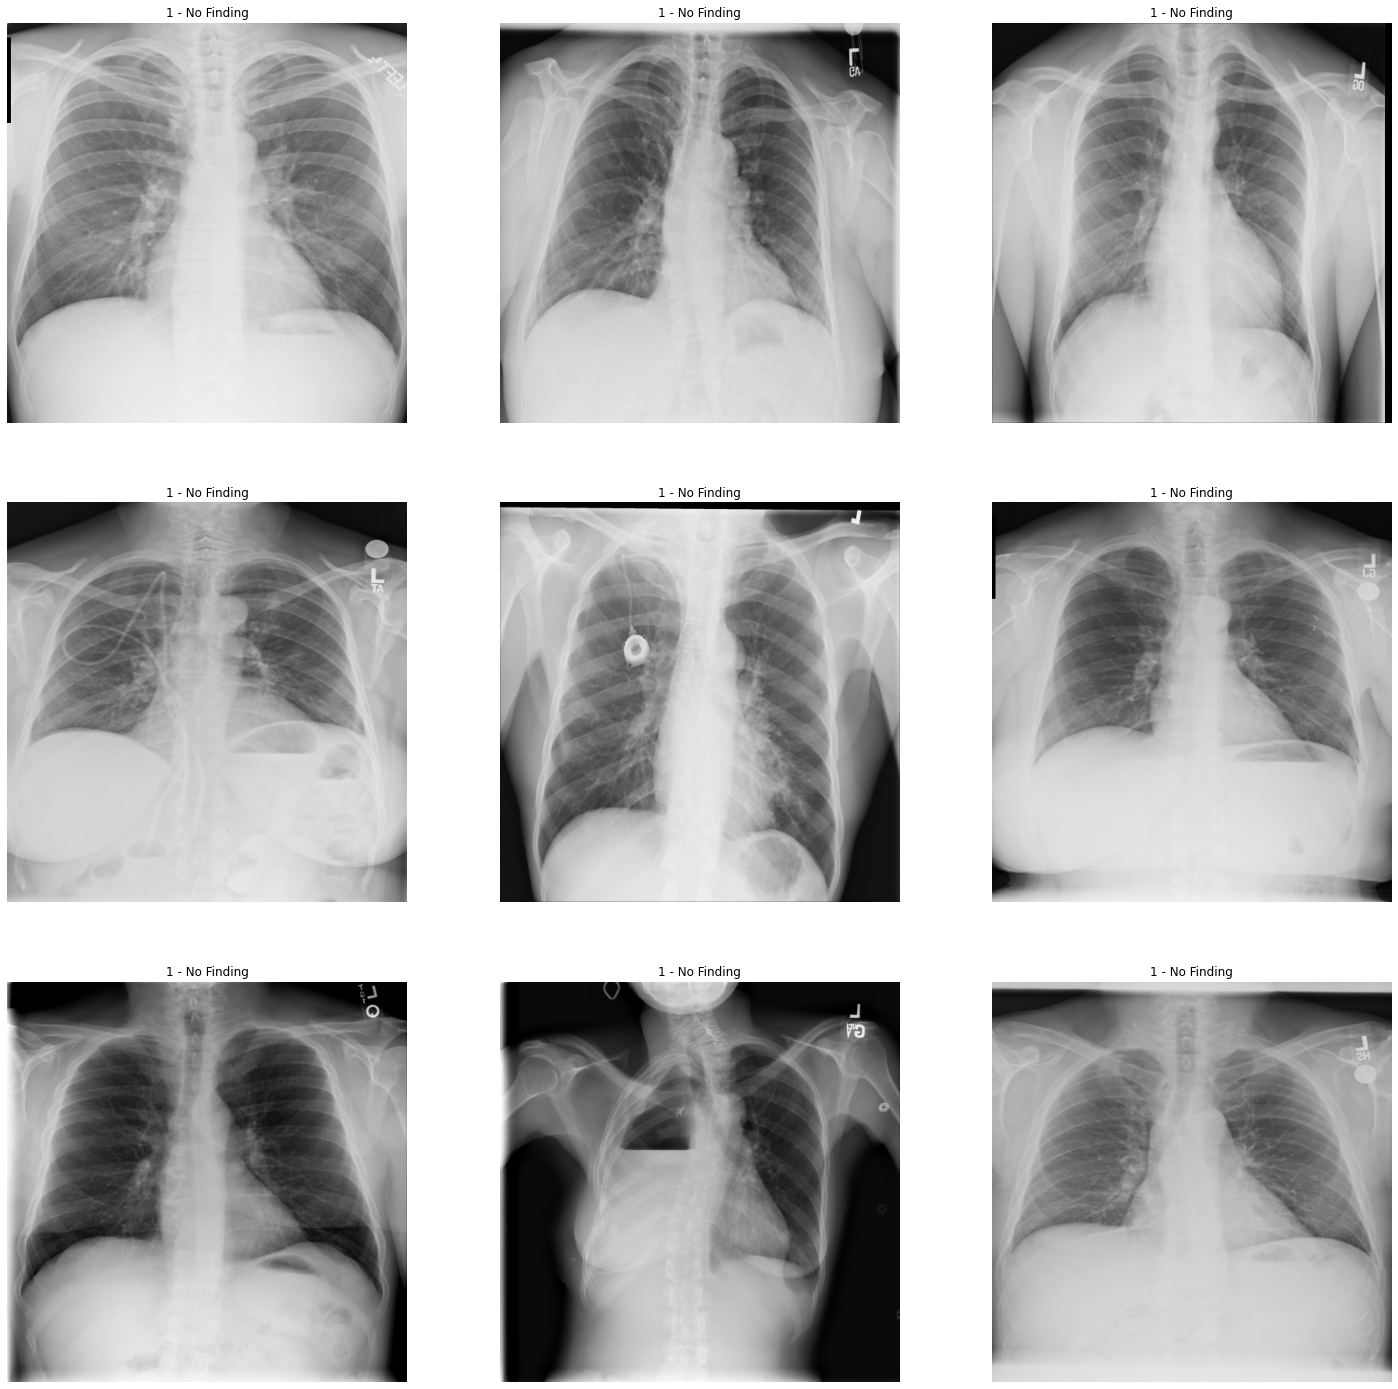

In [14]:
#PLOT SOME IMAGES
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{labels[i]} - " + train_ds.class_names[labels[i]])
        plt.axis("off")
train_ds.class_names

### Calculate Class Weights From Folder/File Structure

In [15]:
#CLASS WEIGHTS AND SAMPLE COUNT
image_folder_path = 'dicom/NIH_1stPA_Norm_Fib'
image_count= []
for dir in train_ds.class_names:
    print(f"{image_folder_path}/{dir}")
    image_count.append(len(glob.glob(f"{image_folder_path}/{dir}/*.png")))
class_weights = {index: max(image_count)/count for index, count in enumerate(image_count)} # convert to a dictionary
TOTAL_SAMPLES=sum(image_count)
class_weights,  TOTAL_SAMPLES, image_count

dicom/NIH_1stPA_Norm_Fib/Fibrosis
dicom/NIH_1stPA_Norm_Fib/No Finding


({0: 10.0, 1: 1.0}, 7007, [637, 6370])

#### UNDERSAMPLING

In [34]:
for line in train_ds.take(1):
    print(len(line))
    print(line[:][1])
# initial_dist = list(np.divide(image_count,TOTAL_SAMPLE))
initial_dist = [0.09,0.91]
target_dist = [0.5, 0.5]
# print(initial_dist)
# initial_dist,target_dist
# def garbage(image_data,image_label):
#     print(image_data)
#     print(tf.squeeze( image_label)[0])
#     return tf.squeeze( image_label)
resampled_dataset = train_ds.rejection_resample(
   class_func=lambda image_data,image_label: tf.squeeze( image_label),
   initial_dist=initial_dist,
   target_dist=target_dist
   )
resampled_dataset = resampled_dataset.map(
    lambda class_func_result, data: data)

2
tf.Tensor([1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)


In [36]:
for line in train_ds.take(1):
    print(len(line))
    print(line[:][1])

2
tf.Tensor([1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1], shape=(32,), dtype=int32)


TRANSFER LEARNING WITH BUILT IN IMAGE RESCALING

In [16]:
# define our transfer learning base model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,  input_shape=(SIZE,SIZE,3), pooling='max')
base_model.trainable = False

# Create a model and train it on the augmented image data
inputs = tf.keras.Input(shape=(SIZE, SIZE, 3))
intermediate = tf.keras.layers.Rescaling(1.0 / 255)(inputs) 
intermediate = base_model(intermediate)

### Create a simple final dense NN layer
outputs = tf.keras.layers.Dense( len(train_ds.class_names), activation = tf.keras.activations.softmax)(intermediate)
### CREATE OUR FINAL MODEL
model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [38]:
# COMPILING THE CNN
model.compile(
  optimizer = 'adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#  logits=TrUe /// loss = 'hinge', 
  metrics = ['accuracy']) #'sparse_categorical_crossentropy'

In [39]:
# SAVE CHECKPOINTS
# generate path wehere you want to save your checkpoints
checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
# define a callback that will save the model weights after every epoch 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  #save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  verbose=1,
  save_best_only=True)

In [43]:
#Train the CNN model, note:batch size is set in the generator
# steps_per_epoch = int(TOTAL_SAMPLES/BATCH_SIZE)
# steps_per_epoch = 10
print(f"EPOCHS: {EPOCHS} --- STEPS/ECHO {steps_per_epoch}");
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, 
  #steps_per_epoch=steps_per_epoch,
  #validation_steps = int(steps_per_epoch*VALIDATION_SPLIT),
  class_weight=class_weights,
  callbacks=[model_checkpoint_callback])

EPOCHS: 2 --- STEPS/ECHO 10
Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 3.7250 - accuracy: 0.6469 
Epoch 1: val_accuracy improved from -inf to 0.35938, saving model to checkpoints/0822-175244_weights.h5
10/10 [==============================] - 257s 25s/step - loss: 3.7250 - accuracy: 0.6469 - val_loss: 1.1943 - val_accuracy: 0.3594
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 2.1597 - accuracy: 0.5000 
Epoch 2: val_accuracy improved from 0.35938 to 0.59375, saving model to checkpoints/0822-175244_weights.h5
10/10 [==============================] - 230s 23s/step - loss: 2.1597 - accuracy: 0.5000 - val_loss: 0.8651 - val_accuracy: 0.5938


In [ ]:
## continue fitting the model
if(False): ##I don't want this to run noramlly
  # load model weights from file
  new_model = keras.models.load_model(checkpoint_path)
  # generate a new path wehere you want to save your checkpoints
  checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
  # define a callback wutg the new path name
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)
  ##RESTART TRAINING
  history = new_model.fit( 
    x_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data = (x_test, y_test), 
    callbacks=[model_checkpoint_callback])
model= keras.models.load_model(checkpoint_path) ## loads most successful version of the fit

##### PLOT RESULTS

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


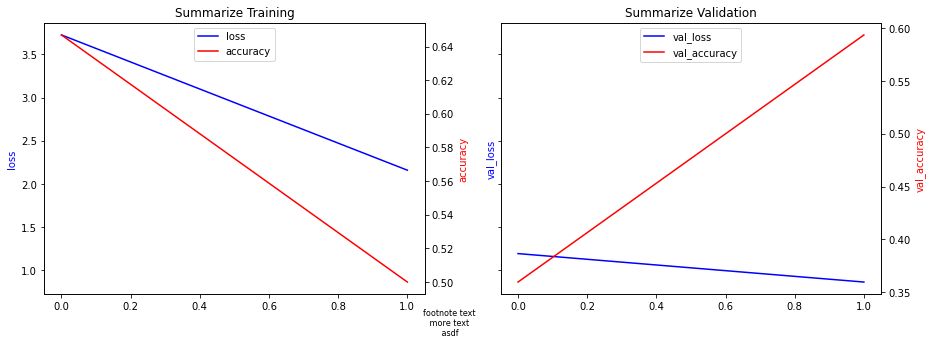

In [44]:
print(history.history.keys())
# summarize training
fig, (ax1,bx1), = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
l1, = ax1.plot(history.history['loss'], color='blue') 
ax2 = ax1.twinx()
l2, = ax2.plot(history.history['accuracy'], color='red')
ax1.set_ylabel('loss' , color='blue')
ax2.set_ylabel('accuracy', color='red' )
plt.legend([l1, l2], ["loss","accuracy" ], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Training')
plt.figtext(0.5, 0.01, 'footnote text\n more text \n asdf', horizontalalignment='center', fontsize=8)
# plt.show()

# summarize validation
# fig, ax1 = plt.subplots()
l1, = bx1.plot(history.history['val_loss'], color='blue') 
bx2 = bx1.twinx()
l2, = bx2.plot(history.history['val_accuracy'], color='red')
bx1.set_ylabel('val_loss' , color='blue')
bx2.set_ylabel('val_accuracy', color='red' )
plt.legend([l1, l2], ["val_loss","val_accuracy" ], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Validation')
plt.show()



In [45]:
predictions = model.predict(
  val_ds,
  #steps=10
) 
predictions 

20/20 [==============================] - 376s 19s/step


array([[0.6371538 , 0.36284617],
       [0.8061887 , 0.19381128],
       [0.6889402 , 0.3110597 ],
       ...,
       [0.20235932, 0.7976406 ],
       [0.55018115, 0.44981882],
       [0.8670975 , 0.13290256]], dtype=float32)

In [51]:
# train_ds.class_names,predictions.shape
# X_test_feature[:9],predictions.shape
# flattened = X_test_feature.argmax(axis=1)
history.history,train_ds.class_names


({'loss': [3.7249596118927, 2.159682273864746],
  'accuracy': [0.6468750238418579, 0.5],
  'val_loss': [1.1942998170852661, 0.8650895357131958],
  'val_accuracy': [0.359375, 0.59375]},
 ['Fibrosis', 'No Finding'])

##### EXTRACT FEATURES USING THE PRETRAINED CNN

In [46]:
#Print overall accuracy
accuracy = metrics.accuracy_score(train_ds.class_names, predictions)
print ("Accuracy = ", accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [2, 640]

In [ ]:
# from sklearn.metrics import confusion_matrix
#Confusion Matrix - verify accuracy of each class
cm = metrics.confusion_matrix(train_ds.class_names, predictions)
#print(cm)
heatmap =sns.heatmap(cm, annot=True)

In [ ]:

#Save confusion matrix
heatmap.get_figure().savefig(f"confusion_matrices/{getTimeStamp()}_VGG16-RF_cats{cm.shape[0]}-{MAX_NUMBER_OF_EACH_FINDING}-{NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING}_size{SIZE}_acc{round(accuracy,2)}.png")

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = label_encoder.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])